# Домашнее задание 3

1) [1 балл] Реализуйте чтение изображений, лежащих в /data/imgs/arrow (как в демо с калибровкой камеры с семинара). Вся обязательная часть задания выполняется с этими изображениями

1) [2 балла] Реализуйте нахождение расстояния от камеры до листка, учитывая, что это тот же листок, что был в первом демо

2) [3 балла] Реализуйте приведение изображения листка к "виду сверху"

3) [6 баллов] Реализуйте определение направления, в котором указывает стрелка. Можно использовать скелетонизацию из первого семинара по зрению: получить маску темной области (стрелки) внутри изображения листка, применить скелетонизацию, вычислить направление. Можно поступить иначе: после нахождения маски вычислить градиенты Собеля по x и y и проанализировать их направления. P.S. Можно использовать и полностью свой метод

4) [3 балла] Доп. задача 1: Примените написанный Вами код к видео https://drive.google.com/file/d/1AQhg2lL5FL4edlOcxY2SHOOZ-v9TgHBD/view?usp=sharing. Загрузите видео на свой гугл диск, а затем дополните имеющийся код монтированием диска и чтением в цикле кадров видео, приведёнными в конце семинара

5) [5 баллов] Доп. задача 2: определите, нормально ли видно листок в кадре. На некоторых кадрах его видно не полностью, один или больше уголков находятся за кадром. Это можно автоматически обнаруживать, к примеру используя размеры стрелки, и выводить на соответствующем кадре маркер - текст или цветную метку

In [8]:
!git clone -b main https://github.com/ivan866/cvr_course

Cloning into 'cvr_course'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 506 (delta 0), reused 3 (delta 0), pack-reused 501
Receiving objects: 100% (506/506), 69.14 MiB | 39.93 MiB/s, done.
Resolving deltas: 100% (114/114), done.


In [ ]:
cd cvr_course/notebooks

In [48]:
import os, math
import numpy as np
import scipy as sp
from scipy.spatial.distance import pdist, squareform
import cv2
from matplotlib import pyplot as plt

In [ ]:
print(os.getcwd())
PATH_GENERIC = '../data/imgs/'
PATH_ARROW = '../data/imgs/arrow/'
#curr_path = PATH_GENERIC
curr_path = PATH_ARROW
#unwarp_flist = ['unwarped.png']
arrow_flist = os.listdir(PATH_ARROW)
#curr_flist = unwarp_flist
curr_flist = arrow_flist

In [12]:
arrow_img = {}
colorcorr_img = {}
thresholded_img = {}
approxed_cnt = {}
#arrow_img['fnamelist'] = []

In [13]:
#READ IMAGES
fname_iter = 0
for fname in curr_flist:
    fpath = '{:s}{:s}'.format(curr_path, fname)
    fname_noext = os.path.splitext(fname)[0]
    img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    arrow_img[fname_iter] = img
    #arrow_img['fnamelist'].append(fname_noext)
    fname_iter += 1

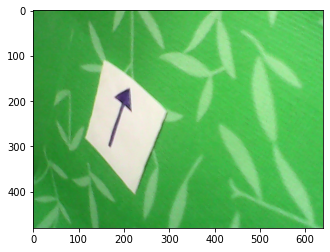

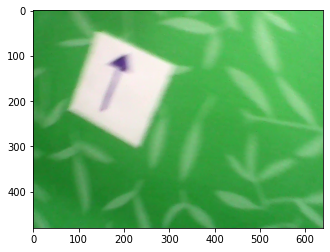

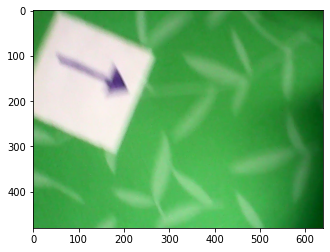

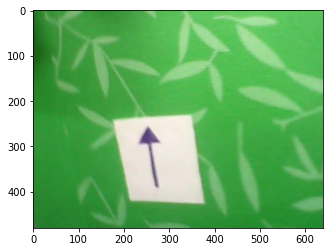

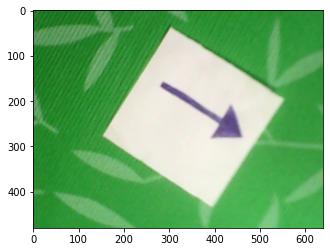

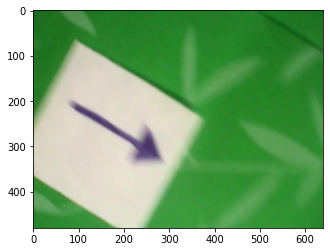

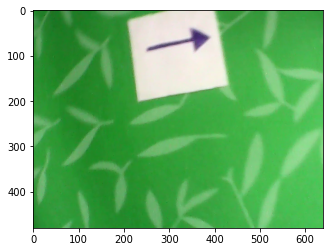

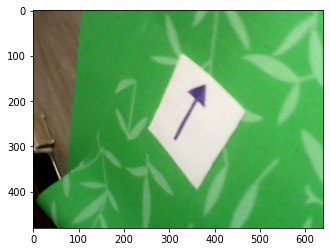

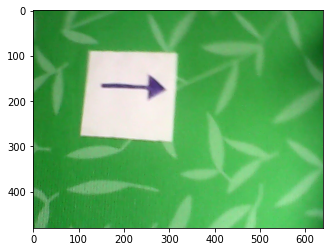

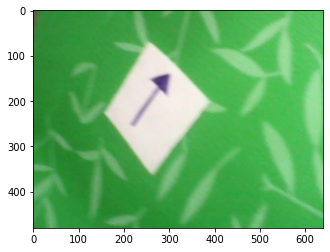

In [14]:
for i in range(len(arrow_img)):
    curr_img = arrow_img[i]
    colorcorr_img[i] = cv2.cvtColor(curr_img, cv2.COLOR_BGR2RGB)
    plt.imshow(colorcorr_img[i])
    plt.show()

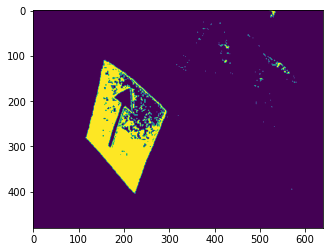

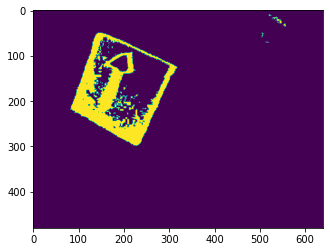

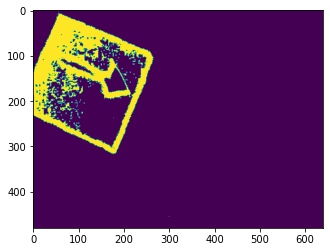

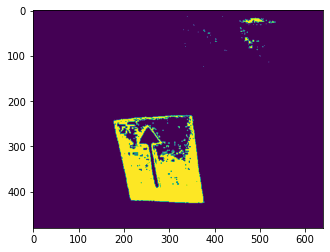

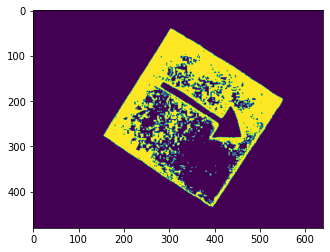

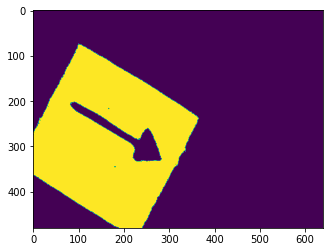

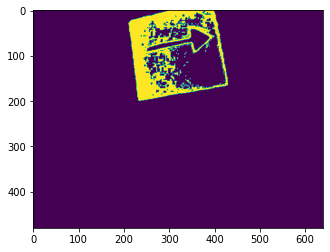

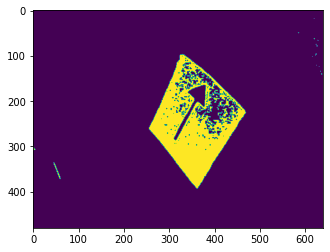

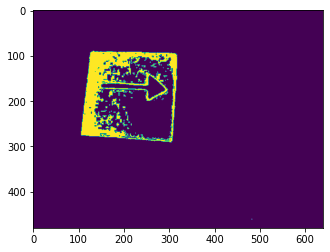

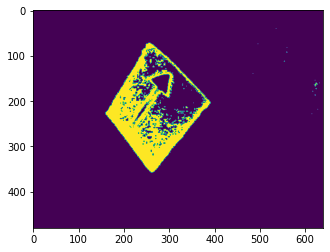

In [15]:
def do_threshold(img, min, max):
    return(cv2.inRange(img, min, max))
thres_min, thres_max = 160, 240
for i in range(len(arrow_img)):
    curr_img = arrow_img[i]
    thresholded_img[i] = do_threshold(curr_img, (thres_min,thres_min,thres_min), (thres_max,thres_max,thres_max))
    plt.imshow(thresholded_img[i])
    plt.show()

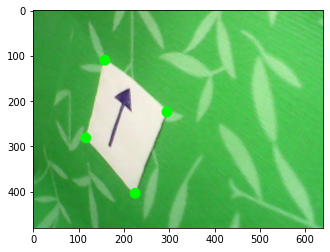

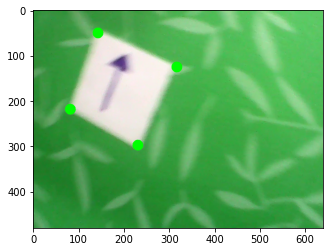

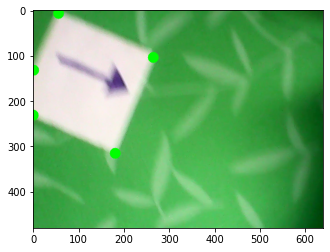

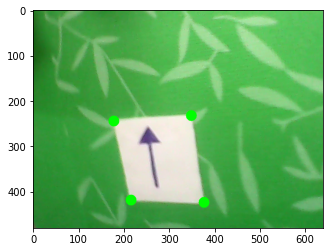

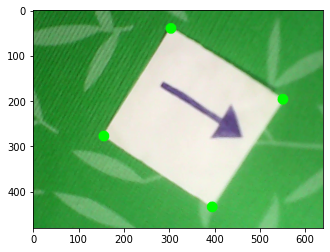

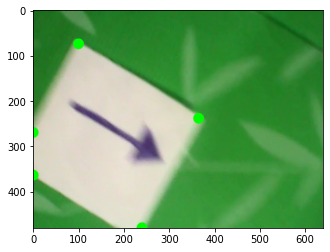

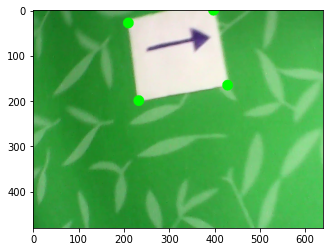

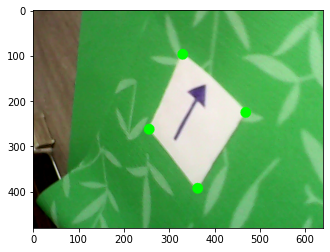

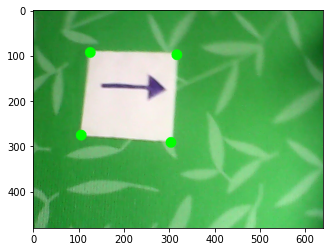

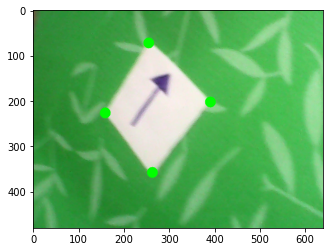

In [16]:
def get_max_len_item(arr):
    l = []
    for i in arr:
        l.append(len(i))
    l = np.array(l)
    return(l.argmax())
def do_approxpoly(thresholded, eps):
    contours, hierarchy = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #ASSUME we need the longest contour
    contours = contours[get_max_len_item(contours)]
    chull = cv2.convexHull(contours)
    eps = cv2.arcLength(chull, True) * eps
    return(cv2.approxPolyDP(chull, eps, True))
COLOR_CORRECT = (0, 255, 0)
COLOR_CAUTION = (255, 0, 0)
COLOR_HILITE = (255, 255, 0)
DOT_SIZE = 24
EPS_K = 0.02
for i in range(len(thresholded_img)):
    #curr_img = arrow_img[i]
    tmp_img = colorcorr_img[i]
    approxed_cnt[i] = do_approxpoly(thresholded_img[i], eps=EPS_K)
    approx_img = cv2.drawContours(tmp_img, approxed_cnt[i], -1, COLOR_CORRECT, DOT_SIZE)
    plt.imshow(approx_img)
    plt.show()

In [17]:
#BUG only works if points are in clockwise ascending order
def order_pts(pts):
    print('pts={}'.format(pts))
    rect = np.zeros((4, 2), dtype='float32')
    s = pts.sum(axis=1)
    rect[0], rect[2] = pts[np.argmin(s)], pts[np.argmax(s)]
    print('argmin={}'.format(np.argmin(s)))
    print('argmax={}'.format(np.argmax(s)))
    diff = np.diff(pts, axis=1)
    print('diff={}'.format(diff))
    rect[1], rect[3] = pts[np.argmin(diff)], pts[np.argmax(diff)]
    return rect
#BUG what if polygon has zero area
#BUG what if diagonals are equal
def rect_unwind(pts):
    rect = np.zeros((4, 2), dtype='float32')
    #find diagonals of the polygon
    distances = squareform(pdist(pts, metric='euclidean'))
    longest_dia = (distances == distances.max()).nonzero()[0]
    pts_remaining = np.setdiff1d([0,1,2,3], [longest_dia[0], longest_dia[1]])
    #first point is always considered the vertex with longest diagonal
    rect[0], rect[2] = pts[longest_dia[0]], pts[longest_dia[1]]
    rect[1], rect[3] = pts[pts_remaining[0]], pts[pts_remaining[1]]
    return(rect)

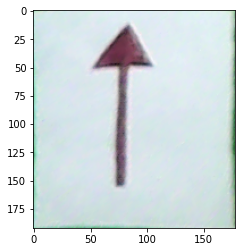

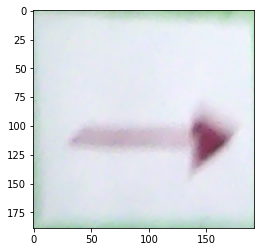

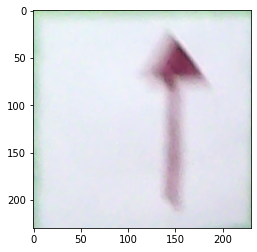

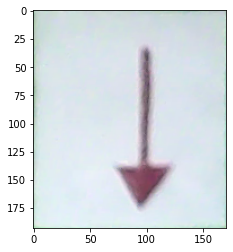

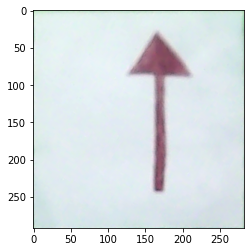

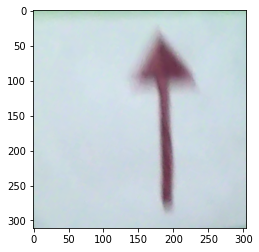

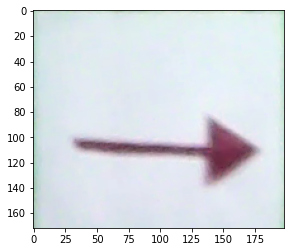

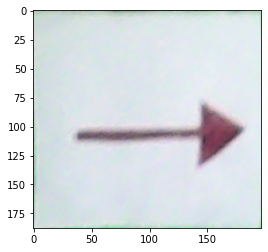

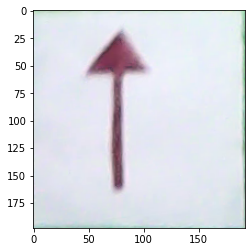

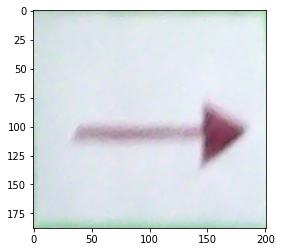

In [18]:
#BIRDEYE VIEW
def do_warp(img, pts):
    rect = rect_unwind(pts)
    (tl, tr, br, bl) = rect
    widthA, widthB = np.linalg.norm(br-bl), np.linalg.norm(tr-tl)
    heightA, heightB = np.linalg.norm(tr-br), np.linalg.norm(tl-bl)
    maxWidth, maxHeight = max(int(widthA), int(widthB)), max(int(heightA), int(heightB))
    dst = np.array([[0, 0],
                    [maxWidth - 1, 0],
                    [maxWidth - 1, maxHeight - 1],
                    [0, maxHeight - 1]], dtype='float32')
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
    return warped
for i in range(len(arrow_img)):
    curr_img = arrow_img[i]
    warped = do_warp(curr_img, np.asarray(approxed_cnt[i])[:,0,:])
    plt.imshow(warped)
    plt.show()

camera distance for this image is 92 cm


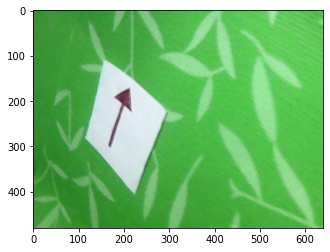

camera distance for this image is 90 cm


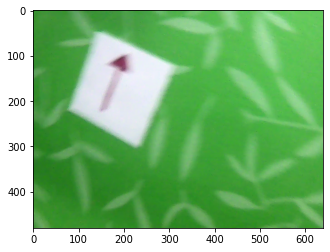

camera distance for this image is 73 cm


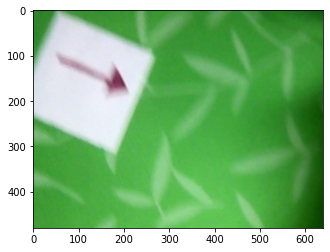

camera distance for this image is 93 cm


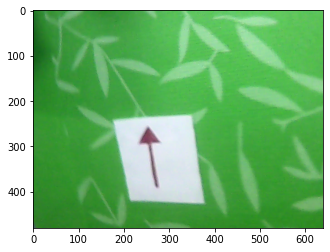

camera distance for this image is 57 cm


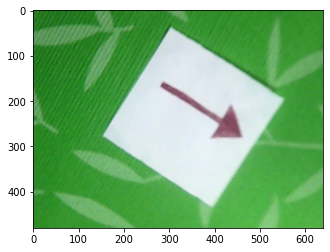

camera distance for this image is 56 cm


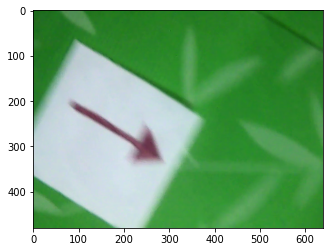

camera distance for this image is 90 cm


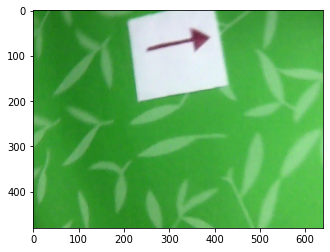

camera distance for this image is 89 cm


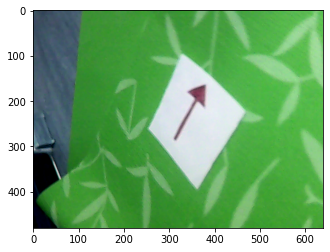

camera distance for this image is 86 cm


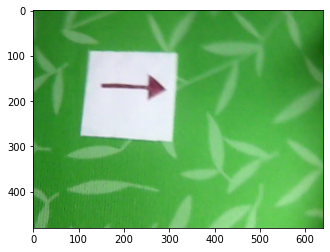

camera distance for this image is 89 cm


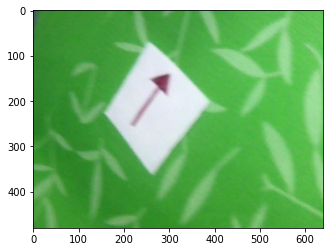

In [19]:
#CAMERA DISTANCE
for i in range(len(approxed_cnt)):   
    curr_img = arrow_img[i]
    cnt = approxed_cnt[i]
    length = cv2.arcLength(cnt, True)
    distance = 180.0 * 364 / length
    print('camera distance for this image is {:.0f} cm'.format(distance))
    plt.imshow(curr_img)
    plt.show()

image 0
arrow orientation is ~18 degrees


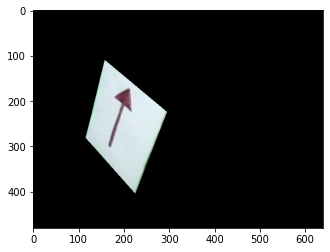

image 1
arrow orientation is ~0 degrees


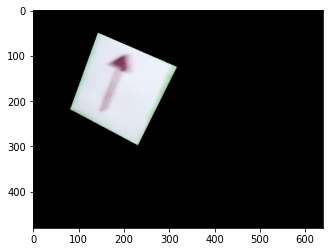

image 2
arrow orientation is ~-243 degrees


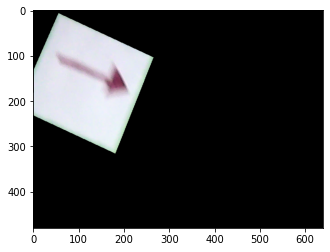

image 3
arrow orientation is ~-180 degrees


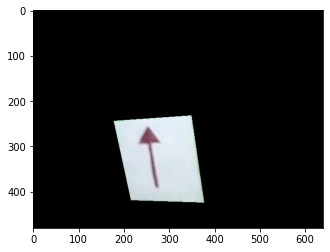

image 4
arrow orientation is ~-238 degrees


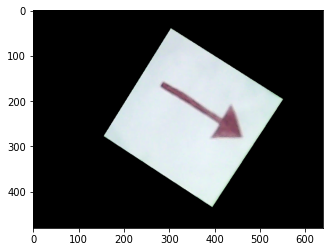

image 5
arrow orientation is ~-238 degrees


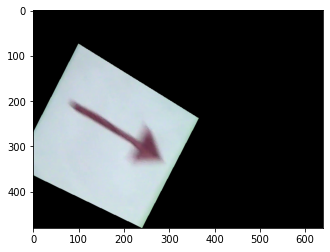

image 6
arrow orientation is ~90 degrees


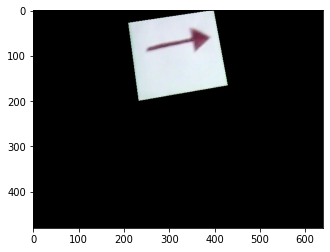

image 7
arrow orientation is ~27 degrees


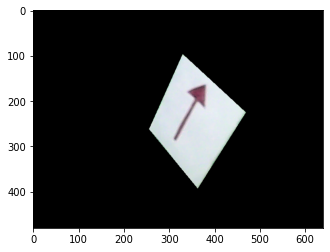

image 8
arrow orientation is ~90 degrees


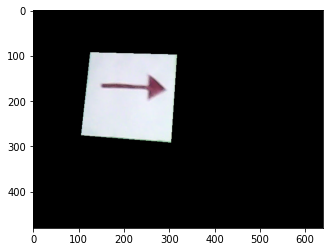

image 9
arrow orientation is ~45 degrees


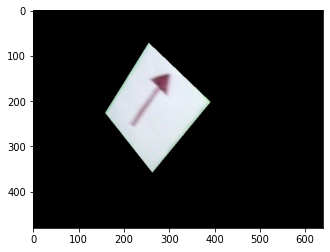

In [20]:
#ARROW ORIENTATION
#BUG fails on image3, 4
#NOTE this line orientation method in rough
element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
def do_crop(img, cnt):
    cnt_mask = np.zeros((img.shape[0],img.shape[1],3), dtype=np.uint8)
    filled = cv2.fillPoly(cnt_mask, [cnt], (255,255,255))
    return(cv2.bitwise_and(curr_img, filled))
def do_thresh(img):
    downscaled = cv2.pyrDown(img)
    gray_img = cv2.cvtColor(downscaled, cv2.COLOR_BGR2GRAY)
    #ada_thresholded = cv2.adaptiveThreshold(gray_img, 128, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 41, 30)
    ret, thresholded = cv2.threshold(gray_img, 204, 255, cv2.THRESH_BINARY_INV)
    return(thresholded)
    #return(cv2.cvtColor(thresholded, cv2.COLOR_GRAY2BGR))
def do_skel(img):
    size = np.size(img)
    skel = np.zeros(img.shape, np.uint8)
    done = False
    while(not done):
        eroded = cv2.erode(img, element)
        dilated = cv2.dilate(eroded, element)
        subtracted = cv2.subtract(img, dilated)
        skel = cv2.bitwise_or(skel, subtracted)
        img = eroded.copy()
        zeros = size - cv2.countNonZero(img)
        if zeros == size:
            done = True
    return(skel)
def do_houghlines(skel):
    return(cv2.HoughLinesP(skel, rho=8, theta=np.pi/180, threshold=70))
    #print(lines[1,0])
for i in range(len(arrow_img)):
    curr_img = arrow_img[i]
    tmp_img = colorcorr_img[i]
    cnt = approxed_cnt[i]
    cropped = do_crop(curr_img, cnt)
    threshed_img = do_thresh(cropped)
    skel = do_skel(threshed_img)
    lines = do_houghlines(skel)
    l = lines[0,0]
    angle = math.atan2(l[1]-l[3], l[0]-l[2])
    print('image {:.0f}'.format(i))
    print('arrow orientation is ~{:.0f} degrees'.format(angle/np.pi*180-90))
    plt.imshow(cropped); plt.show()
    #plt.imshow(threshed_img); plt.show()
    #plt.imshow(skel); plt.show()
    #cv2.line(curr_img, (l[0],l[1]), (l[2],l[3]), COLOR_CAUTION, 6)
    #cv2.arrowedLine(curr_img, (l[0],l[1]), (l[2],l[3]), color=COLOR_HILITE, thickness=3)

In [42]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=False)

Mounted at /content/drive/
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
chdir: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
/bin/bash: line 0: cd: ../../drive/MyDrive: Transport endpoint is not connected


In [ ]:
cd ../../drive/MyDrive

In [44]:
#VIDEO FEED
#NOTE rect unwinder fails on frame126, 172-176 [>4 points]
#video_frm = {}
tmp_frm = {}
video_thresholded = {}
video_cnt = {}
video1 = cv2.VideoCapture('3.mov')
frm_iter = 0
while(video1.isOpened()):
    ret, frame = video1.read()
    print('frame# {:.0f}'.format(frm_iter))
    if ret:#and frm_iter<2
        #video_frm[frm_iter] = frame
        tmp_frm[frm_iter] = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        video_thresholded[frm_iter] = do_threshold(frame, (thres_min,thres_min,thres_min), (thres_max,thres_max,thres_max))
        video_cnt[frm_iter] = do_approxpoly(video_thresholded[frm_iter], eps=EPS_K)
        approx_img = cv2.drawContours(tmp_frm[frm_iter], video_cnt[frm_iter], -1, COLOR_CORRECT, DOT_SIZE)
        warped_img = do_warp(frame, np.asarray(video_cnt[frm_iter])[:,0,:])
        #plt.imshow(frame); plt.show()
        plt.imshow(video_thresholded[frm_iter]); plt.show()
        plt.imshow(approx_img); plt.show()
        plt.imshow(warped_img); plt.show()
    else:
        break
    frm_iter += 1
video1.release()